In [1]:
#!jupyter nbconvert --to script 1-preprocessing.ipynb

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import pickle
from os import path
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
import warnings

# Disable typecast warnings
warnings.filterwarnings('ignore')

na_values=['NA', 'nan']

dtype = {'tiprel_1mes':np.str, 'indrel_1mes':np.str, 'fecha_alta':np.str, 'fecha_dato':np.str, 'ult_fec_cli_1t':np.str}

iter_csv = pd.read_csv('../data/raw/train.csv.zip', na_values = na_values, skipinitialspace = True, 
                       iterator=True, chunksize=100000, dtype=dtype)

df = pd.concat([chunk for chunk in iter_csv], ignore_index=True)

In [4]:
products = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
            'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
            'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
            'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
            'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
            'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
            'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
            'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

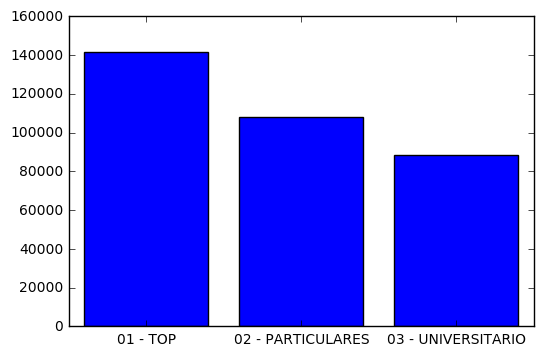

In [5]:
segm_rent = defaultdict(set)
df.groupby(['segmento']).apply(lambda x: segm_rent[x.segmento.values[0]].add(x.renta.median()))

keys = []
vals = []

for k, v in segm_rent.items():
    keys.append(k)
    vals.append(list(v)[0])
    
fig, ax = plt.subplots()
ind = np.arange(len(keys))  # the x locations for the groups

ax.bar(ind, vals, align='center')
ax.set_xticks(ind)
ax.set_xticklabels(keys)
plt.show()

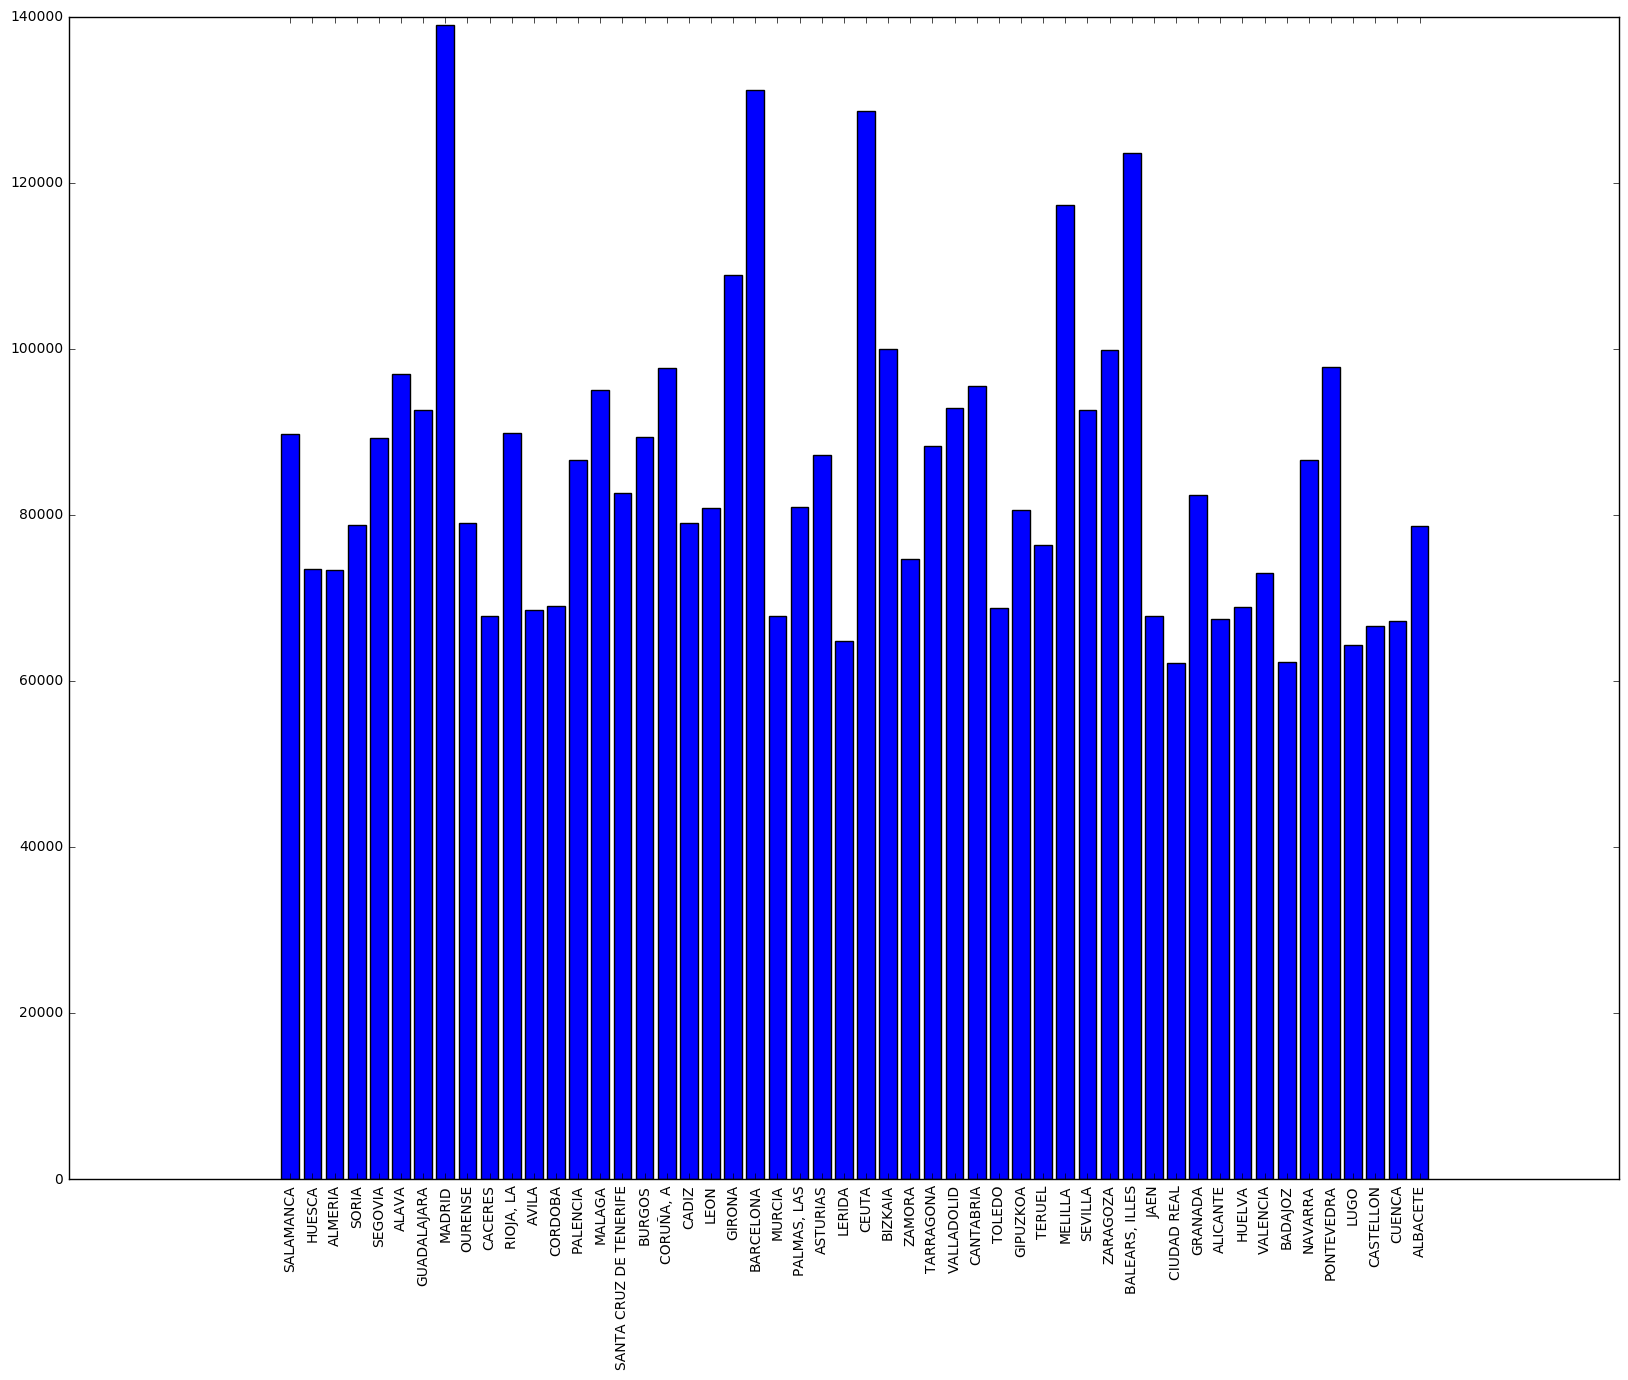

In [6]:
prov_rent = defaultdict(set)
df.groupby(['nomprov']).apply(lambda x: prov_rent[x.nomprov.values[0]].add(x.renta.median()))

keys = []
vals = []

for k, v in prov_rent.items():
    keys.append(k)
    vals.append(list(v)[0])
    
fig, ax = plt.subplots(figsize=(20, 15))
ind = np.arange(len(keys))  # the x locations for the groups

ax.bar(ind, vals, align='center')
ax.set_xticks(ind)
ax.set_xticklabels(keys, rotation='vertical')
plt.show()

In [7]:
grouped = df.groupby(["nomprov", "segmento"]).agg({"renta":lambda x: x.median(skipna=True)})

In [8]:
grouped.head()

renta
nomprov  segmento                     
ALAVA    01 - TOP             55271.07
         02 - PARTICULARES   164007.12
         03 - UNIVERSITARIO   74453.79
ALBACETE 01 - TOP             88457.49
         02 - PARTICULARES    81777.15

In [9]:
for (prov, segm) in grouped.index.get_values():
    df.ix[(df.renta.isnull()) & (df.nomprov == prov) & (df.segmento == segm), 'renta'] = grouped.loc[prov, segm].values[0]
    df.ix[(df.renta.isnull()) & (df.nomprov == prov), 'renta'] = grouped.renta.loc[prov, :].mean()
    df.ix[(df.renta.isnull()) & (df.segmento == segm), 'renta'] = grouped.renta.loc[grouped.index.get_level_values('segmento') == segm].mean()
    
df.ix[df.renta.isnull(), 'renta'] = df.renta.mean()

In [10]:
personal_products = {}

# this function checks whether any product was bought in provided months a year ago.
def month_last_year(user_history, months):  
    active = []
    
    for m in months:
        curr = '2015-0%d-28' % m
        entry = user_history[user_history.fecha_dato == curr]
        if len(entry) > 0:

            for p in products:
                if entry.iloc[0][p] == 1:
                    active.append(p)
                
    return active
   
# this function collects products which where used more than {percent} of time.
# here {percent} is a fraction from 0 to 1 inclusive. 50% == 0.5
def popular_products(user_history, percent):
    active = []

    for p in products:
        curr = user_history[p][user_history[p].notnull()].values
        usage = (curr == 1).sum()/curr.size
        if usage >= percent:
            active.append(p)
    
    return active

i = 0

def grab_personal(rows):
    user_history = rows.copy(deep=True)
    user_history.reset_index(drop=True, inplace=True)
    
    global i
    print('loc', user_history.loc[0]['ncodpers'])
    print('iloc', user_history.iloc[0]['ncodpers'])
    if i % 10000 == 0:
        print('processing entry #%d' % i)
    i += 1

    potential = []
    potential.extend(month_last_year(user_history, [6,5,7]))
    potential.extend(popular_products(user_history, 0.5))

    active_prods = user_history.iloc[-1][products]

    for p in products:
        if active_prods[p] == 1:
            potential = [e for e in potential if e != p]
            
    personal_products[user_history.iloc[0]['ncodpers']] = products

In [11]:
PERS_PRODS = '../data/processed/personal.pickle'

if path.isfile(PERS_PRODS):
    print('File already exists. Start loading...')
    with open(PERS_PRODS, 'rb') as f:
        personal_products = pickle.load(f)
    print('Done!')
else:
    print('Calculating...')    
    corrupted.groupby(['ncodpers']).apply(grab_personal)
    with open(PERS_PRODS, 'wb') as f:
        pickle.dump(personal_products, f)

File already exists. Start loading...
Done!


In [12]:
df.drop_duplicates(['ncodpers'], keep='last', inplace=True)
df = df[df.age.notnull()]
df = df[df.sexo.notnull()]
df.sort_values(['ncodpers', 'fecha_dato'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
len(df.ncodpers.unique())

949609

In [15]:
def sub_code_and_toint(text):
    return 0.0 if pd.isnull(text) else float(str(text)[1:2])
    
def preprocess_features(X):    
    columns_to_drop = ['fecha_alta', 'ult_fec_cli_1t', 'conyuemp',
                       'canal_entrada', 'indfall', 'tipodom', 'nomprov']
    
    dummies = ['ind_empleado', 'indrel_1mes', 'indrel_1mes', 'tiprel_1mes', 'segmento']
    
    X.drop(columns_to_drop, axis=1, inplace=True) 

    # sexo
    X.sexo.replace(to_replace=['V', 'H'], value=[1.0, 0.0], inplace=True)
    
    # ind_empleado
    ind_empleado = pd.get_dummies(X.ind_empleado, prefix = 'ind_empleado')
    X = pd.concat([X, ind_empleado], axis=1)
    
    # ind_nuevo
    X.ix[(X.ind_nuevo.isnull()) & (X.antiguedad.isnull()), 'ind_nuevo'] = 0
    X.ix[(X.ind_nuevo.isnull()) & (X.antiguedad < 6), 'ind_nuevo'] = 1
    X.ix[(X.ind_nuevo.isnull()) & (X.antiguedad >= 6), 'ind_nuevo'] = 0
    
    # indrel
    X.indrel.replace(to_replace=[99.], value=[0.], inplace=True)
    
    # indrel_1mes
    X.indrel_1mes.replace(to_replace=['P', float('nan')], value=[5., 6.], inplace=True)
    indrel_1mes = pd.get_dummies(X.indrel_1mes, prefix = 'indrel_1mes')
    X = pd.concat([X, indrel_1mes], axis=1)   
    
    # tiprel_1mes
    X.tiprel_1mes.replace(to_replace=[float('nan')], value=['N'], inplace=True)
    tiprel_1mes = pd.get_dummies(X.tiprel_1mes, prefix = 'tiprel_1mes')
    X = pd.concat([X, tiprel_1mes], axis=1)   
    
    # indresi
    X.indresi.replace(to_replace=['S', 'N'], value=[1.0, 0.0], inplace=True) 
    
    # indext
    X.indext.replace(to_replace=['S', 'N'], value=[1.0, 0.0], inplace=True) 
    
    # cod_prov
    X.cod_prov.replace(to_replace=[float('nan')], value=[0.], inplace=True)
    
    # segmento
    segmento = pd.get_dummies(X.segmento, prefix = 'segmento')
    X = pd.concat([X, segmento], axis=1)  
    
    X.drop(dummies, axis=1, inplace=True)   
    
    return X

In [16]:
df = preprocess_features(df)

In [17]:
len(df.ncodpers.unique())

949609

In [19]:
df.drop(['fecha_dato', 'pais_residencia'], axis=1, inplace=True)
df.head()

,ncodpers,sexo,age,ind_nuevo,antiguedad,indrel,indresi,indext,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,ind_empleado_A,ind_empleado_B,ind_empleado_F,ind_empleado_N,ind_empleado_S,indrel_1mes_5.0,indrel_1mes_6.0,indrel_1mes_1,indrel_1mes_1.0,indrel_1mes_2,indrel_1mes_2.0,indrel_1mes_3,indrel_1mes_3.0,indrel_1mes_4,indrel_1mes_4.0,tiprel_1mes_A,tiprel_1mes_I,tiprel_1mes_N,tiprel_1mes_P,tiprel_1mes_R,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO
0,15889,1.0,56.0,0.0,255.0,1.0,1.0,0.0,28.0,1.0,326124.900000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,15890,1.0,63.0,0.0,256.0,1.0,1.0,0.0,28.0,1.0,71461.200000,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,15891,0.0,59.0,0.0,246.0,0.0,1.0,0.0,28.0,0.0,87942.006923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,15892,0.0,62.0,0.0,256.0,1.0,1.0,0.0,28.0,1.0,430477.410000,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,15893,1.0,63.0,0.0,256.0,1.0,1.0,0.0,28.0,1.0,430477.410000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
df.to_csv('../data/processed/train-processed.csv.gz', index=False, compression='gzip')